# Logistic Regression

### Table of Contents
1. [Introduction](#Introduction)
2. [Importing and Cleaning the Data](#Importing-and-Cleaning-the-Data)
3. [Making The Model](#Making-The-Model)
4. [Further Investigation](#Further-Investigation)
5. [How does the proportion of high income individuals vary by sex?](#How-does-the-proportion-of-high-income-individuals-vary-by-sex?)
6. [References](#References)

# Introduction

In this section we will give a brief overview of what Logistic Regression is and how it works, without getting too technical. This brief explanation is compiled with the help of sources [\[1\]](#References) and [\[2\]](#References).

Logistic Regression is a method for modelling the probability that a response variable belongs to a particular category. In our example, we would be modelling the probability that an individual earns more or less than 50k a year based upon the features. To achieve this the logistic function is used, also known as the sigmoid function. This function is as follows:

$$p = \frac{1}{1+e^{-y}}$$

Which is used to map any real number to a value between 0 and 1. If we then apply this to the linear regression model: $y = \beta_0 + \beta_1 X_1 + ... + \beta_n X_n$, we get:

$$p = \frac{1}{1+e^{-(\beta_0 + \beta_1 X_1 + ... + \beta_n X_n)}}$$

Where the $\beta_i$ are the coefficients of the model, which are often predicted using maximum likelihood estimates (MLE). This is done by considering the likelihood function:

$$l(\beta_0, \beta_1, ... ,\beta_n) = \prod_{i:y_i=1} p(x_i) \cdot \prod_{j:y_j=0} (1-p(x_j))$$

Where $y_i$ are the target variables, and $p(X) = Pr(Y = 1|X)$ where $X$ are the features. Intuitively, maximising this function involves getting it as close to 1 as possible, which would predict values of $p(x_i)$ that are as close to the desired probability as possible, which is what we want.

### Assumptions of Logistic Regression

The Logistic Regression model makes a few key assumptions about the data being used, some of the main ones are: [\[3\]](#References)

* The target variable takes the form of discrete data, in particular: binary, multinomial, or ordinal. In our case the target is binary.
* The observations need to be independent of each other, so there are no repeated rows. Each row of our data corresponds to a different individual so there are no duplicates.
* There is little or no multicollinearity among the independent variables (features). This may not strongly apply to our dataset.
* The model assumes linearity of the independent variables and log odds, i.e. it assumes a linear decision surface, which may not apply to our data.

These assumptions will be considered and discussed in document 04.3-Discussion.

# Importing and Cleaning the Data

We starting by importing our required modules.

In [1]:
######## REQUIREMENTS #################
### PLEASE RUN THIS CELL FIRST ########
#######################################

import subprocess
import sys

# List of required packages
required_packages = ['numpy','pandas', 'matplotlib','sklearn','statsmodels','seaborn']

# Function to check and install packages
def install(package):
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

# Check and install required packages
for package in required_packages:
    try:
        __import__(package)
        print(f"'{package}' is already installed.")
    except ImportError:
        print(f"'{package}' not found. Installing...")
        install(package)

print("\nAll required packages are checked/installed.")

'numpy' is already installed.
'pandas' is already installed.
'matplotlib' is already installed.
'sklearn' is already installed.
'statsmodels' is already installed.
'seaborn' is already installed.

All required packages are checked/installed.


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

Next we will import the data, this is done by reading it directly from the data folder in the repository.

In [23]:
# Load the saved datasets from the CSV files
X_train = pd.read_csv("../data/X_train.csv", index_col=0)  # Use the first column as index
y_train = pd.read_csv("../data/y_train.csv", index_col=0)  # Use the first column as index
X_test = pd.read_csv("../data/X_test.csv", index_col=0)    # Use the first column as index
y_test = pd.read_csv("../data/y_test.csv", index_col=0)    # Use the first column as index

# Display the first few rows of the training datasets to ensure it has been loaded correctly
pd.DataFrame.join(X_train,y_train).head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Now we will need to do some cleanup of the data. For Logistic Regression we need all of the features to be numbers, but currently we have a mix of both int64 and object data.

In [24]:
X_train.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
dtype: object

So we factorise the features, converting each different string for the column into an integer, and storing the key as a list for later use if necessary. We have to be careful for this though as if we factorize the testing and training data separately, there may be data which appears in one dataset but not the other, and so the keys will end up being different. To deal with this we briefly concatinate the dataframes, then factorise the data, then convert them back. We need to do this for both the features and the targets.

In [25]:
# Concatinate the datasets, keeping the positional data
X_all = pd.concat({'X_train':X_train, 'X_test':X_test})

# Then we factorize
objects = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
keys = [0]*len(objects)

for i in range(len(objects)):
    X_all[objects[i]], keys[i] = pd.factorize(X_all[objects[i]])

# Then we return the original test train split
X_train = X_all.loc['X_train']
X_test = X_all.loc['X_test']

# And finally check that the data is in the correct form
X_train.dtypes

age               int64
workclass         int64
fnlwgt            int64
education         int64
education-num     int64
marital-status    int64
occupation        int64
relationship      int64
race              int64
sex               int64
capital-gain      int64
capital-loss      int64
hours-per-week    int64
native-country    int64
dtype: object

In [26]:
y_train.dtypes # We see that the target dataset has the same problem.

income    object
dtype: object

In [27]:
# Concatinate the datasets, keeping the positional data
y_all = pd.concat({'y_train':y_train, 'y_test':y_test})

# Then we factorize
y_all['income'], income_key = pd.factorize(y_all['income'])

# Then we return the original test train split
y_train = y_all.loc['y_train']
y_test = y_all.loc['y_test']

y_train.dtypes

income    int64
dtype: object

# Making The Model

We now make the model. We use the versatile scikit-learn module for this, which has many built in functions that will be helpful for our analysis.

In [28]:
# Create logistic regression object
lr = linear_model.LogisticRegression()

# Train the model using the training sets
lr.fit(X_train,y_train.values.ravel())

# Make predictions using the testing set
y_pred = lr.predict(X_test)

# Score the model
print(lr.score(X_train,y_train))
print(lr.score(X_test,y_test))

0.7982601699602756
0.7908028231142479


C:\Users\Sheri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


We see that we get a score of about 0.79, but also get a warning, encouraging the use of preprocessing the data. We will explore this now. The scaling that scikit-learn recommends is some simple transformations to get the data into the form of normally distributed data, with mean 0 and variance 1. The module has a built in function to do this. We also make use of the module's built in pipeline commands, which can apply a transformation to the data and then apply the model to it all in one command. This code is modified from [\[4\]](#References).

In [29]:
# Create the pipeline. This scales the data and then applies the regression model onto it.
pipe = make_pipeline(StandardScaler(), linear_model.LogisticRegression())

# Train the model on the training data and then use that to predict on the test data, as before.
pipe.fit(X_train, y_train.values.ravel())
y_pred2 = pipe.predict(X_test)

# Score the model
trainscore = pipe.score(X_train, y_train)
print(trainscore)
testscore = pipe.score(X_test, y_test)
print(testscore)

0.8258912857645698
0.8201367445963829


We see that this simple scaling has increased our accuracy to around 0.82. This may seem like a small improvement, but if we compare the ROC (Receiver Operating Characteristic) curves and the AUC (Area Under Curve) values, we see that overall this actually represents a significant improvement. So moving forward we will use this scaled data.

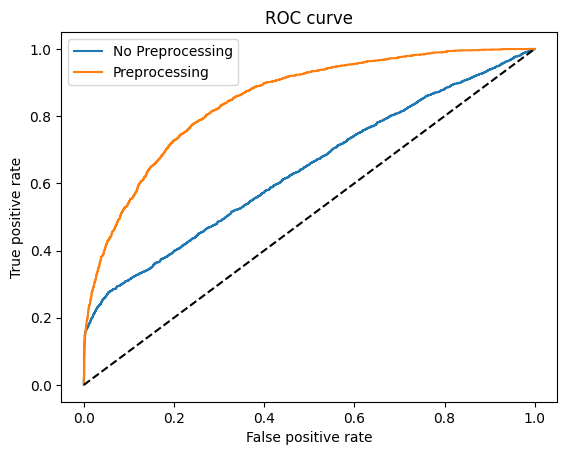

In [30]:
def plot_roc(models : list, labels : list):
    for model in models:
        y_predprob = model.predict_proba(X_test)
        fpr,tpr,_ = roc_curve(y_test,y_predprob[:,1])
        plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(labels)

plot_roc([lr,pipe],['No Preprocessing','Preprocessing'])

In [31]:
for model in [lr,pipe]:
    y_predprob = model.predict_proba(X_test)
    fpr,tpr,_ = roc_curve(y_test,y_predprob[:,1])
    val = auc(fpr,tpr)
    print(f'AUC = {val} for Model: {model}')

AUC = 0.6397057269157828 for Model: LogisticRegression()
AUC = 0.8480098063282541 for Model: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])


# Further Investigation

We can compare the model's score with a value known as the null accuracy, which is given by simply guessing the most common outcome as the prediction for each value. In our case we have:

In [32]:
y_test.value_counts()

income
0         6862
1         2206
Name: count, dtype: int64

And so we see that the most common outcome is 0, and so we calculate the accuracy that we would predict by simple guessing 0 as every outcome:

In [33]:
null_accuracy = (6862/(6862+2206))

print('Null accuracy score: {0:0.4f}'. format(null_accuracy))
print('Our training score: {0:0.4f}'.format(trainscore))
print('Our testing score: {0:0.4f}'.format(testscore))

Null accuracy score: 0.7567
Our training score: 0.8259
Our testing score: 0.8201


We see that our model does in fact perform better than the null accuracy, meaning that our model is working and predicting values correctly. However, our score is still not that high and we will explore a few ways of potentially improving this in the next document, however these attempts are largely unsuccessful, leading us to conclude that the model is not easily improvable. See the next document for more information.

Another metric that we can look at to investigate the accuracy of the model is a confusion matrix. A confusion matrix shows 4 values, true and false positives and negatives.

In [34]:
cm = confusion_matrix(y_test,y_pred2)
print(cm)

[[6486  376]
 [1255  951]]


This is hard to read though and we will instead plot a heatmap, with code from [\[1\]](#References).

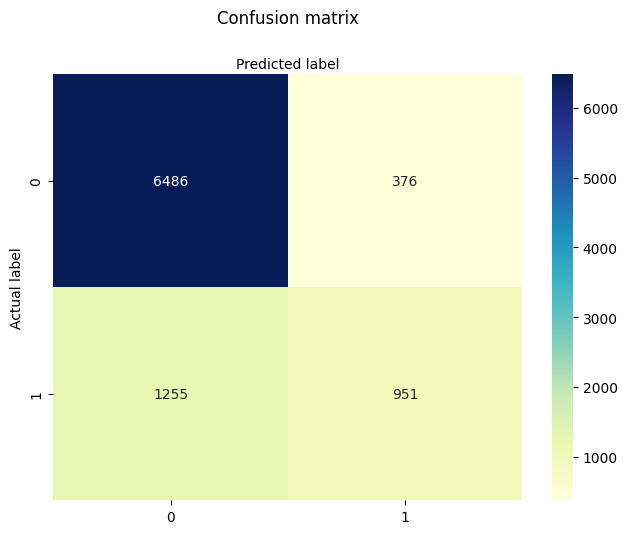

In [35]:
class_names=[0,1] # name of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

We thus see that from the test data, $6486 + 951 = 7437$ of the cases were predicted correctly, whilst $1255 + 376 = 1631$ were predicted incorrectly, with there being around 4 times as many False Negatives (bottom left) as False Positives (top right). We can investigate this further using the `classification_report` function provided by sklearn.

In [36]:
target_names = income_key # We use the income key created during fatorisation to rename the target categories.
print(classification_report(y_test,y_pred2, target_names = target_names))

              precision    recall  f1-score   support

       <=50K       0.84      0.95      0.89      6862
        >50K       0.72      0.43      0.54      2206

    accuracy                           0.82      9068
   macro avg       0.78      0.69      0.71      9068
weighted avg       0.81      0.82      0.80      9068



An explanation of the column names is copied below, taken from the sklearn documentation: [\[5\]](#References)

>The precision is the ratio `tp / (tp + fp)` where `tp` is the number of true positives and `fp` the number of false positives. The precision is intuitively the ability of the classifier not to label a negative sample as positive.

>The recall is the ratio `tp / (tp + fn)` where `tp` is the number of true positives and `fn` the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

>The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.
The F-beta score weights recall more than precision by a factor of `beta`. `beta == 1.0` means recall and precision are equally important.

>The support is the number of occurrences of each class in y_true.

A notable feature of this report is the low recall for `>50K`. This suggests that the model is not very good at finding the positive samples for this category. This could be for many reasons, a big one is probably the imbalance in the data, with `<=50K` having over 3 times as many individuals compared to `>50K`.

# How does the proportion of high income individuals vary by sex?

One way to investigate the significance of the features is to look at the p-values for the respective feature. Scikit-learn does not provide this feature natively so we will use the statsmodels module for this part instead.

In [37]:
# Once again scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),index=X_train.index,columns=X_train.columns)

# Apply the model. Logit is Logistic Regression
logit_model=sm.Logit(y_train,X_train_scaled)
result=logit_model.fit()
# Print a summary of the results
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.462815
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 income   No. Observations:                39774
Model:                          Logit   Df Residuals:                    39760
Method:                           MLE   Df Model:                           13
Date:                Fri, 25 Oct 2024   Pseudo R-squ.:                  0.1573
Time:                        22:20:10   Log-Likelihood:                -18408.
converged:                       True   LL-Null:                       -21844.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
age                0.4309      0.015     28.442      0.000       0.401       0.461
workclass        

The main takeaways from these p-values (the column titled P>|z|), is that native-country is not significant. Relationship also has a relatively high p-value, but as it falls under the usual threshold of p = 0.05, we still consider it important. Apart from those, all other features would be considered significant for the model.

Looking at the `sex` feature, the p-value suggests it does in fact have a significant impact on the yearly income but doesn't clue us in to how much or for if males or females are more likely to have a higher income. To give us an idea of that, we can look at the coefficient given by the model. We see that `sex` has a coefficient of -0.3912. What this tells us is that for every unit increase in the `sex` variable, the log-odds of the outcome decreases by 0.3912, assuming that the other predictor variables are held constant. If we look back to our key to see how the `sex` feature was factorised, we see that `male` was encoded as 0, and `female` was encoded as 1:

In [38]:
print(keys[6])

Index(['Male', 'Female'], dtype='object')


Combining all this information, this model suggests that females have a 0.3912 lower log-odds to earn more than 50k a year compared to males. Converting this log odds to a probability, by calculating exp(-0.3912) = 0.676254..., we have that females are around 32.4% less likely than males to earn more than 50k a year, according to this model.

# References

[1] Datacamp: Understanding Logistic Regression in Python - https://www.datacamp.com/tutorial/understanding-logistic-regression-python?dc_referrer=https%3A%2F%2Fwww.google.com%2F

[2] An Introduction to Statistical Learning with Applications in Python - https://www.statlearning.com/

[3] Logistic Regression Classifier Tutorial - https://www.kaggle.com/code/prashant111/logistic-regression-classifier-tutorial

[4] Scikit-Learn User Guide: 6.3. Preprocessing Data - https://scikit-learn.org/stable/modules/preprocessing.html

[5] Scikit-Learn Documentation: precision_recall_fscore_support - https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support